In [1]:
# Importamos las librerías necesarias
%matplotlib inline
import matplotlib.pyplot as plt
from pennylane import numpy as np
import pennylane as qml

In [2]:
# Definimos los parámetros de la molécula que buscamos simular
# Elementos de la molécula
elementos = ["H", "H"]
coordenadas = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614])
electrones = 2

In [3]:
# Creamos el Hamiltoniano de la molécula y el número de qubits
# necesarios para su simulación
# Creamos la molécula
molecula = qml.qchem.Molecule(elementos, coordenadas)

# Obtenemos el Hamiltoniano y el número de qubits
H, qubits = qml.qchem.molecular_hamiltonian(molecula)

# Imprimimos el número de qubits y el Hamiltoniano
print("Qubits = ", qubits)
print("Hamiltoniano:  ", H)

Qubits =  4
Hamiltoniano:   -0.042072551947439224 * I(0) + 0.1777135822909176 * Z(0) + -0.2427450126094144 * Z(2) + 0.12293330449299361 * (Z(0) @ Z(2)) + 0.1777135822909176 * Z(1) + 0.17059759276836803 * (Z(0) @ Z(1)) + 0.044750084063019925 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.044750084063019925 * (Y(0) @ Y(1) @ X(2) @ X(3)) + -0.044750084063019925 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.044750084063019925 * (X(0) @ Y(1) @ Y(2) @ X(3)) + -0.2427450126094144 * Z(3) + 0.16768338855601356 * (Z(0) @ Z(3)) + 0.12293330449299361 * (Z(1) @ Z(3)) + 0.16768338855601356 * (Z(1) @ Z(2)) + 0.1762766139418181 * (Z(2) @ Z(3))


In [4]:
# Definimos el estado base de Hartree-Fock
hf = qml.qchem.hf_state(electrones, qubits)

# Imprimimos el estado base de Hartree-Fock
print(hf)

[1 1 0 0]


In [5]:
# Definimos las excitaciones de los electrones
singles, doubles = qml.qchem.excitations(electrones, qubits, delta_sz=0)

# Imprimimos las excitaciones de los electrones
print(singles)
print(doubles)

[[0, 2], [1, 3]]
[[0, 1, 2, 3]]


In [6]:
# Implementamos un circicuito que implemente
#  las excitaciones de los electrones
def circuit(params, wires):
    qml.AllSinglesDoubles(params, wires, hf, singles, doubles)

In [7]:
# Definimos el dispositivo que vamos a utilizar
dev = qml.device("lightning.qubit", wires=qubits)

In [8]:
# Definimos la función de coste
@qml.qnode(dev, interface="autograd")
def cost_fn(params):
    circuit(params, wires=range(qubits))
    return qml.expval(H)

In [9]:
# Definimos el operador spin total S2
S2 = qml.qchem.spin2(electrones, qubits)

In [10]:
# Definimos elcircuito para el valor esperado
# de S2
@qml.qnode(dev, interface="autograd")
def S2_exp_value(params):
    circuit(params, wires=range(qubits))
    return qml.expval(S2)

In [11]:
# Calculamos le valor del Spin total
def spin_total(params):
    return -0.5 + np.sqrt(1 / 4 + S2_exp_value(params))

In [12]:
# Definimos el optimizador
opt = qml.GradientDescentOptimizer(stepsize=0.35)
np.random.seed(0)  

# Definimos el valor inicial de los parámetros del circuito
theta = np.random.normal(0, np.pi, len(singles) + len(doubles) ,requires_grad=True)
print(theta)

[5.54193389 1.25713095 3.07479606]


In [13]:
max_iter = 100
stop_criteria = 1e-05
energy_results = []
spin_results = []

# Bucle de optimización
for n in range(max_iter):

    # Calculamos le valor de los parámetos y el gradiente
    #  de la energía
    theta, prev_energy = opt.step_and_cost(cost_fn, theta)

    # Calculamos el valor de la energía y el spin para los
    #  parámetros actuales
    energy = cost_fn(theta)
    spin = spin_total(theta)

    # Calculamos la convergencia como la diferencia entre 
    # la energía actual y la anterior
    conv = np.abs(energy - prev_energy)
    
    # Imprimimos los resultados cada 4 iteraciones
    if n % 4 == 0:
        print(f"Iteración = {n}, Energía = {energy:.8f} Ha", f"Spin = {spin:.5f}")

    # Comprobamos si se ha alcanzado el criterio de parada
    if conv <= stop_criteria:
        print(f"\n" f"Convergencia alcanzada en la iteración {n}")
        break
    
    # Guardamos los resultados
    energy_results.append(energy)
    spin_results.append(spin)
    

# Imprimimos los resultados finales
print("\n" f"Aproximación a la energía del estado fundamental = {energy:.5f} Ha")
print("\n" f"Aproximación al spin del estado fundamental = {spin:.5f}")
print("\n" f"Parámetreos óptimos del circuito = {theta}")

Iteración = 0, Energía = 0.03873360 Ha Spin = 0.07996
Iteración = 4, Energía = -0.40990433 Ha Spin = 0.12873
Iteración = 8, Energía = -0.73458829 Ha Spin = 0.11137
Iteración = 12, Energía = -0.95554777 Ha Spin = 0.05814
Iteración = 16, Energía = -1.07290383 Ha Spin = 0.02163
Iteración = 20, Energía = -1.11645751 Ha Spin = 0.00695
Iteración = 24, Energía = -1.13024314 Ha Spin = 0.00214
Iteración = 28, Energía = -1.13441323 Ha Spin = 0.00065
Iteración = 32, Energía = -1.13565998 Ha Spin = 0.00020
Iteración = 36, Energía = -1.13603158 Ha Spin = 0.00006
Iteración = 40, Energía = -1.13614224 Ha Spin = 0.00002

Convergencia alcanzada en la iteración 42

Aproximación a la energía del estado fundamental = -1.13616 Ha

Aproximación al spin del estado fundamental = 0.00001

Parámetreos óptimos del circuito = [3.15190158 3.1369829  2.93181786]


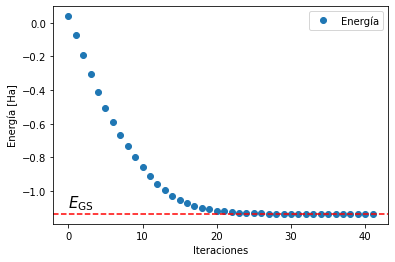

<Figure size 432x288 with 0 Axes>

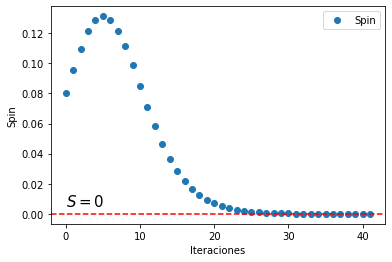

In [84]:
# Representamos gráficamente la convergencia de los algoritmos
# Energía del estado fundamental
E_gs = -1.13619
plt.figure()
plt.plot(energy_results,'o', label="Energía")
plt.axhline(y=E_gs, color='r', linestyle='--')
plt.xlabel("Iteraciones")
plt.ylabel("Energía [Ha]")
plt.text(0, -1.1, r"$E_\mathrm{GS}$", fontsize=15)
plt.legend()
plt.savefig("energy.png",dpi = 300)
plt.show()



# Spin del estado fundamental
plt.figure()
plt.plot(spin_results,'o', label="Spin")
plt.axhline(y=0, color='r', linestyle='--')
plt.text(0, 0.005, r"$S = 0$", fontsize=15)
plt.xlabel("Iteraciones")
plt.ylabel("Spin")
plt.legend()
plt.savefig("spin.png", dpi=300)

In [36]:
# Construimos el estado resultado del proceso de optimización
@qml.qnode(dev)
def optimized_state(params, wires):
    qml.AllSinglesDoubles(params, wires, hf, singles, doubles)
    return qml.state()

# Get the optimized state
optimized_state_rounded = [np.round(x, 3) 
                           for x in optimized_state(theta, wires=range(qubits))]

print(optimized_state_rounded)

[0j, 0j, 0j, (0.105+0j), 0j, 0j, (0.001+0j), 0j, 0j, (-0+0j), 0j, 0j, (-0.995+0j), 0j, 0j, 0j]
